# SUMO

In this notebook, we will use the SUMO simulator to simulate a simple traffic scenario. We will use the TraCI API to interact with the simulation.

First lets define the needed imports and constants.


In [1]:
import random
import threading
from time import sleep
import networkx as nx

from lxml import etree
from networkx.generators.random_graphs import dual_barabasi_albert_graph

net_file = "BerlinSumo/osm.net.xml.gz"
route_file = "BerlinSumo/osm.passenger.trips.xml"
gml_file = "BerlinSumo/osm.net.gml"
SUMO_CFG = "./BerlinSumo/osm.sumocfg"


Let's convert the net file to a gml file to visualize the network.

Now we can visualize the network using the GML file.

Let's do it using the `networkx` library and `matplotlib`.

Read the GML file and visualize the network.

In [2]:

def convert_to_simple_graph(input_path, output_path):
    try:
        # Parse the XML file
        tree = etree.parse(input_path)
        root = tree.getroot()

        G = nx.Graph()  # Create an undirected graph

        nodes = set()
        edges = set()

        # Extract edges
        for edge in root.findall("edge"):
            from_node_id = edge.attrib.get("from")  # Safely get the 'from' attribute
            to_node_id = edge.attrib.get("to")  # Safely get the 'to' attribute
            # print all attributes of the edge
            print(edge.attrib)
            # add from_node_id to nodes if it is not none
            if from_node_id is not None:
                nodes.add(from_node_id)
            if to_node_id is not None:
                nodes.add(to_node_id)

            # edge id
            edge_id = edge.attrib.get("id")

            # add the edge to the edges set
            edges.add((from_node_id, to_node_id, edge_id))

        for node in nodes:
            G.add_node(node)

        valid_edges = list()

        for edge in edges:
            if edge[0] is not None and edge[1] is not None:
                if len(edge) != 3:
                    print(f"Invalid edge: {edge}")
                    #G.add_edge(edge[0], edge[1],edge[2])
                G.add_edge(edge[0], edge[1])
                valid_edges.append(edge)

        # Write the graph to a GML file
        nx.write_gml(G, output_path)
        print(f"Graph conversion completed. GML file saved to: {output_path}")

        return valid_edges

    except Exception as e:
        print(f"Error during conversion: {e}")


sumo_edge_ids = convert_to_simple_graph(net_file, gml_file)
sumo_edge_ids


{'id': ':1001074218_0', 'function': 'internal'}
{'id': ':10189040386_0', 'function': 'internal'}
{'id': ':10189040387_0', 'function': 'internal'}
{'id': ':10287240229_0', 'function': 'internal'}
{'id': ':10287240229_1', 'function': 'internal'}
{'id': ':10287240229_3', 'function': 'internal'}
{'id': ':10287240229_2', 'function': 'internal'}
{'id': ':10287240230_0', 'function': 'internal'}
{'id': ':10287240230_1', 'function': 'internal'}
{'id': ':10287240230_2', 'function': 'internal'}
{'id': ':10287240230_3', 'function': 'internal'}
{'id': ':10298577286_0', 'function': 'internal'}
{'id': ':10556620135_0', 'function': 'internal'}
{'id': ':10556620135_1', 'function': 'internal'}
{'id': ':10723176862_0', 'function': 'internal'}
{'id': ':10880725066_0', 'function': 'internal'}
{'id': ':11062133273_0', 'function': 'internal'}
{'id': ':11062133273_1', 'function': 'internal'}
{'id': ':11124714790_0', 'function': 'internal'}
{'id': ':11124714790_2', 'function': 'internal'}
{'id': ':11392391984_

[('266540994', '266540992', '-4611714#8'),
 ('25663436', '3345707083', '23755718#0'),
 ('25661397', '25662562', '-155186522#1'),
 ('29207828', '25663713', '-375311153#1'),
 ('25662562', '2959830775', '153698380#0'),
 ('cluster_25661976_271747430_4605644865',
  'cluster_4605644862_545110995_545119977_960119785',
  '1105574292#0'),
 ('25661366', '11062133273', '4597326#0'),
 ('545036879', '29207837', '-1127602092#0'),
 ('cluster_1772850071_660263399', '29208244', '563341815#0'),
 ('283039345', '283039344', '-35557161#2'),
 ('25662542', '25661386', '-4588220#2'),
 ('29208244', 'cluster_1772850071_660263399', '-563341815#2'),
 ('2959830775', '25662562', '-153698380#2'),
 ('cluster_160514854_283035794',
  'cluster_3922684684_3922684686_3922684691_545036683',
  '-831860725#2'),
 ('3213618590', '29207858', '4611718#1'),
 ('25661966', '25662928', '4588219#0'),
 ('29063088', '9824731426', '-1151333060'),
 ('25663150', '25663142', '1151333058#0'),
 ('29208248', '29207825', '-375459781#1'),
 ('25

In [3]:
len(sumo_edge_ids)

379

## Visualize the GML file

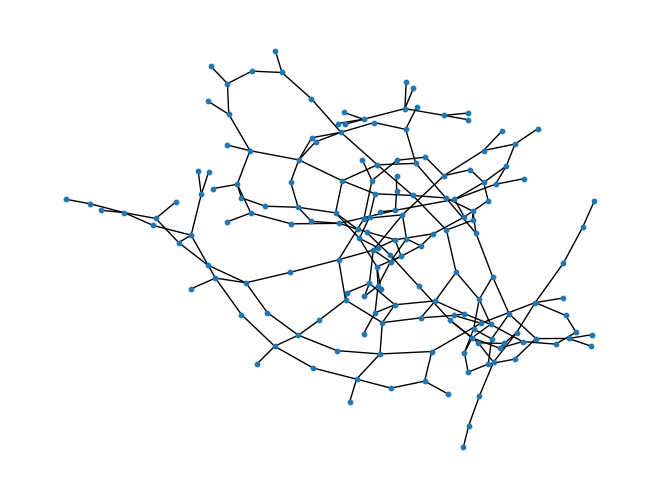

In [4]:
import matplotlib.pyplot as plt

G = nx.read_gml(gml_file)
# dont't show node names and make nodes smaller
nx.draw(G, with_labels=False, node_size=10)
plt.show()

In [11]:
# Count of edges and vertices in
len(G.edges), len(G.nodes)

(219, 169)

Let's do sumo simulation.

In [5]:
import traci
import time
import PartialHomomorphyScheme

# Path to your SUMO configuration file

def run_phe():
    phe_sim = PartialHomomorphyScheme.Simulation("Berlin", gml_file, quiet=False, sleep_time=0.2,
                                                 traffic_update_interval_in_seconds=20,
                                                 key_size=2048, sumo_edge_ids=sumo_edge_ids)


    def run_simulation():
        # Start SUMO using the configuration file
        traci.start(["sumo", "-c", SUMO_CFG])

        simulation_time_step = 0
        interval = 10  # Interval in seconds

        try:
            while traci.simulation.getMinExpectedNumber() > 0:
                traci.simulationStep()  # Advance the simulation by one step

                execute_every_interval(simulation_time_step)

                simulation_time_step += 1
                time.sleep(1)  # Pause for real-time simulation
        except Exception as e:
            print(f"Error during simulation: {e}")
        finally:
            traci.close()  # Close SUMO connection

    max_vehicles = 0

    def execute_every_interval(simulation_time_step):
        global max_vehicles
        print(f"Executing custom code at simulation time {simulation_time_step} seconds")
        # Retrieve and print the location of all vehicles
        vehicle_ids = traci.vehicle.getIDList()
        max_vehicles = max(max_vehicles, len(vehicle_ids))
        if not vehicle_ids:
            print("No vehicles in the simulation at this step.")
            return

        for veh_id in vehicle_ids:
            speed_m_s = traci.vehicle.getSpeed(veh_id)  # Speed in m/s
            speed_kmh = int(speed_m_s * 3.6)  # Convert to km/h
            position = traci.vehicle.getPosition(veh_id)  # Get the (x, y) coordinates
            edge_id = traci.vehicle.getRoadID(veh_id)
            print(f"Vehicle {veh_id}: Speed = {speed_kmh} km/h, Position = {position}, Edge =     {edge_id}")
        phe_sim.send_sumo_traffic(sumo_edge_id=edge_id, speed=speed_kmh)

    threading.Thread(target=run_simulation).start()
    phe_sim.run()
    phe_sim.end_run()
    return phe_sim.get_simulation_data()

run_phe()

## Simulate for singe blockchain scheme

In [14]:
import traci
import time
import SingleBlockchainScheme

def run_single():
    single_sim = SingleBlockchainScheme.Simulation("Berlin", quiet=False, gml_file=gml_file,     sleep_time=0.2,
                                                   traffic_update_interval_in_seconds=20,
                                                   sumo_edge_ids=sumo_edge_ids)

    def execute_every_interval(simulation_time_step):
        print(f"Executing custom code at simulation time {simulation_time_step} seconds")
        # Retrieve and print the location of all vehicles
        vehicle_ids = traci.vehicle.getIDList()
        if not vehicle_ids:
            print("No vehicles in the simulation at this step.")
            return
        for veh_id in vehicle_ids:
            speed_m_s = traci.vehicle.getSpeed(veh_id)
            speed_kmh = int(speed_m_s * 3.6)
            position = traci.vehicle.getPosition(veh_id)
            edge_id = traci.vehicle.getRoadID(veh_id)
            print(f"Vehicle {veh_id}: Speed = {speed_kmh} km/h, Position = {position}, Edge =     {edge_id}")
            single_sim.send_sumo_traffic(sumo_edge_id=edge_id, speed=speed_kmh)

    def run_simulation():
        # Start SUMO using the configuration file
        traci.start(["sumo", "-c", SUMO_CFG])

        simulation_time_step = 0

        try:
            while traci.simulation.getMinExpectedNumber() > 0:
                traci.simulationStep()  # Advance the simulation by one step

                execute_every_interval(simulation_time_step)

                simulation_time_step += 1
                time.sleep(1)  # Pause for real-time simulation
        except Exception as e:
            print(f"Error during simulation: {e}")
        finally:
            traci.close()  # Close SUMO connection

    threading.Thread(target=run_simulation).start()
    single_sim.run()
    single_sim.end_run()
    return single_sim.get_simulation_data()

run_single()

hello
/Users/parsa/VanetBlockchain
Starting simulation
Added street graph edges to blockchain
Sent traffic log for edge ('1818648902', '546292274') with speed 86
Sent traffic log for edge ('25661991', '25661997') with speed 41
Sent traffic log for edge ('25664673', '25664841') with speed 23
Sent traffic log for edge ('2071423333', '25662916') with speed 19
Sent traffic log for edge ('25663714', '283039347') with speed 6
Sent traffic log for edge ('10287240229', '283039343') with speed 43
Sent traffic log for edge ('6879458154', '29207842') with speed 12
Sent traffic log for edge ('25663714', '11646819817') with speed 49
Sent traffic log for edge ('3980157313', '25661397') with speed 19
Sent traffic log for edge ('25663401', '25663409') with speed 72
Sent traffic log for edge ('1818648896', '1818648902') with speed 84
Sent traffic log for edge ('30507148', '29207433') with speed 50
Sent traffic log for edge ('283039344', '25662738') with speed 39
Sent traffic log for edge ('29207839', '

{'calculating_average_traffic_time': 0.004895,
 'average_traffic_block_size': 8218,
 'blockchain_data_size': 20676,
 'sending_traffic_logs_time': 0.000709}

In [10]:
import traci
import time
import TwoBlockchainsScheme

def run_dual():
    dual_sim = TwoBlockchainsScheme.Simulation("Berlin", quiet=False, gml_file=gml_file,     sleep_time=0.2,
                                                   traffic_update_interval_in_seconds=20,
                                                   sumo_edge_ids=sumo_edge_ids)

    def execute_every_interval(simulation_time_step):
        print(f"Executing custom code at simulation time {simulation_time_step} seconds")
        # Retrieve and print the location of all vehicles
        vehicle_ids = traci.vehicle.getIDList()
        if not vehicle_ids:
            print("No vehicles in the simulation at this step.")
            return
        for veh_id in vehicle_ids:
            speed_m_s = traci.vehicle.getSpeed(veh_id)
            speed_kmh = int(speed_m_s * 3.6)
            position = traci.vehicle.getPosition(veh_id)
            edge_id = traci.vehicle.getRoadID(veh_id)
            print(f"Vehicle {veh_id}: Speed = {speed_kmh} km/h, Position = {position}, Edge =     {edge_id}")
            dual_sim.send_sumo_traffic(sumo_edge_id=edge_id, speed=speed_kmh)

    def run_simulation():
        # Start SUMO using the configuration file
        traci.start(["sumo", "-c", SUMO_CFG])

        simulation_time_step = 0

        try:
            while traci.simulation.getMinExpectedNumber() > 0:
                traci.simulationStep()  # Advance the simulation by one step

                execute_every_interval(simulation_time_step)

                simulation_time_step += 1
                time.sleep(1)  # Pause for real-time simulation
        except Exception as e:
            print(f"Error during simulation: {e}")
        finally:
            traci.close()  # Close SUMO connection

    threading.Thread(target=run_simulation).start()
    dual_sim.run()
    dual_sim.end_run()
    return dual_sim.get_simulation_data()

run_dual()

/Users/parsa/VanetBlockchain
Starting simulation
Added street graph edges to blockchain
Sent traffic log for edge ('2264199819', '21487242') with speed 54
Sent traffic log for edge ('11392391984', '25661997') with speed 18
Sent traffic log for edge ('25664779', '25664841') with speed 18
Sent traffic log for edge ('25663401', '25663409') with speed 7
Sent traffic log for edge ('cluster_25665646_3602294175', 'cluster_3378459427_3378459431') with speed 37
Sent traffic log for edge ('20246257', '2045820585') with speed 77
Sent traffic log for edge ('25662041', '25661969') with speed 79
Sent traffic log for edge ('25661984', '1711812123') with speed 27
Sent traffic log for edge ('11720027616', '4457861306') with speed 34
Sent traffic log for edge ('283039344', '25662738') with speed 53
Sent traffic log for edge ('25661397', '25662562') with speed 22
Sent traffic log for edge ('26708008', '29063088') with speed 90
Sent traffic log for edge ('6879458154', '29207842') with speed 93
Sent traffi

{'calculating_average_traffic_time': 0.007002,
 'average_traffic_block_size': 8179,
 'local_blockchain_data_size': 17447,
 'global_blockchain_data_sze': 8205,
 'sending_traffic_logs_time': 0.000767}